# Clouds: Young Planet Spectroscopy

What you will learn:

1. How are clouds expected to shape planet spectra across a range of effective temperatures?
2. How does this impede our ability to differentiate formation scenarios

What you should know:

1. What do formation models predict for the effective temperatures of young planets across different masses?
2. Given identical luminosity and age, can formation scenarios and mass be determined?
3. How do we dissect spectroscopy of planet atmospheres in order to infer atmospheric physical properties such as abundance and climate profiles?

**Additional setup requirements:**

This is a **bonus** notebook and will require one last setup step. This notebook relies on the cloud code `virga`, which should already be installed with your `PICASO` installation. However, in order for `virga` to work you need to **download** the cloud optical condensates (about 10 Mb):

https://zenodo.org/record/3992294#.YN1CXxNKjlw

Once you do that you will have to define the path to the condensates (see this next cell)

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi

import virga

jpi.output_notebook()
import os
import pandas as pd
import numpy as np
#point to your sonora profile grid that you untared (see above cell #2)
# sonora_profile_db = '/data/sonora_profile/'
sonora_profile_db = os.path.join(os.getenv('picaso_refdata'),'sonora_grids','bobcat')
#see additional path here!!!
# mieff_dir = '/data/virga/'
mieff_dir = os.path.join(os.getenv('picaso_refdata'),'virga')

Loading BokehJS ...

In [2]:
wave_range = [1,5]
opa = jdi.opannection(wave_range=wave_range)

## How do clouds affect an atmospheric spectrum compared to the cloud free cases?

In the previous workbook, we computed a sequence of spectra as a function of temperature along the hot start formation scenario. Now we will repeat the exercise while adding in cloud models.

We will use the cloud model, `virga` which is baked into `PICASO`.

In [3]:
case_study = jdi.evolution_track(mass=8, age='all')

Let's take a feasible subset of these.

In [4]:
i_to_compute = case_study['hot'].index[0::15]#take every 15th value

### Cloud free spectra

Let's run PICASO in a loop with the different effective temperatures and gravities

In [5]:
yph = jdi.inputs()
#let's keep the star fixed
yph.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
yph.phase_angle(0)

#Let's stick the loop in right here!
hot_output={} #easy mechanism to save all the output
for i in i_to_compute:
    Teff = case_study['hot'].loc[i,'Teff']
    grav = case_study['hot'].loc[i,'grav_cgs']
    yph.gravity(gravity= grav,
                gravity_unit=jdi.u.Unit('cm/s**2'))
    yph.sonora(sonora_profile_db,  Teff)
    hot_case = yph.spectrum(opa,calculation='thermal', full_output=True)
    hot_output[f'{Teff}_{grav}'] = hot_case

### Cloudy spectra

Now that we know how to run cloudy models, let's recompute our sequence with clouds.

There are a few more parameters that we have to specify with regards to the cloud code:

- metallicity and mean molecular weight (should be consistent with your atmosphere profile)
- f$_{sed}$: sedimentation efficiency, which controls the vertical extent of the cloud deck. For more information see: https://natashabatalha.github.io/virga/notebooks/1_GettingStarted.html#How-to-pick-f_{sed}
- K$_{zz}$: vertical mixing
- Gas condensates: in general, you should think carefully about what gases you want to set as condensable. For this exercise we will just look at a subset four potential condensates for simplicity. See [Gao et al. 2021](#References) for a more in depth discussion of condensates in exoplanet atmospheres.

In [6]:
yph = jdi.inputs()
#let's keep the star fixed
yph.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
yph.phase_angle(0)

#Let's stick the loop in right here!
cldy_hot_output={} #easy mechanism to save all the output
cld_output={}
for i in i_to_compute:
    Teff = case_study['hot'].loc[i,'Teff']
    grav = case_study['hot'].loc[i,'grav_cgs']
    yph.gravity(gravity= grav,
                gravity_unit=jdi.u.Unit('cm/s**2'))
    yph.sonora(sonora_profile_db,  Teff)
    p=yph.inputs['atmosphere']['profile']['pressure']
    t=yph.inputs['atmosphere']['profile']['temperature']

    #NEW CLOUD STUFF
    metallicity = 1 #1xSolar
    mean_molecular_weight = 2.2
    fsed=1
    gas_condensates = ['H2O','MnS','Mg2SiO4','Al2O3']

    #for the cloud code we have to supply a kzz value, which describes the degree of mixing
    yph.inputs['atmosphere']['profile']['kz'] = [1e9]*len(p)

    cld_output[f'{Teff}_{grav}'] = yph.virga(gas_condensates, mieff_dir, fsed=fsed,mh=metallicity,
                 mmw = mean_molecular_weight)

    hot_case = yph.spectrum(opa,calculation='thermal', full_output=True)
    cldy_hot_output[f'{Teff}_{grav}'] = hot_case

Not doing sublayer as cloud deck at the bottom of pressure grid


Not doing sublayer as cloud deck at the bottom of pressure grid
Not doing sublayer as cloud deck at the bottom of pressure grid


Not doing sublayer as cloud deck at the bottom of pressure grid
Not doing sublayer as cloud deck at the bottom of pressure grid
Not doing sublayer as cloud deck at the bottom of pressure grid


Let's plot the sequence!!

In [7]:
wno,spec=[],[]
fig = jpi.figure(height=500,width=500, y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='Flux (erg/s/cm2/cm)')
delta_fig = jpi.figure(height=500,width=500, #y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='% Diff Cloud Free - Cloudy')
#CLOUD FREE
for i,ikey in enumerate(hot_output.keys()):
    x,y1 = jdi.mean_regrid(hot_output[ikey]['wavenumber'],
                          hot_output[ikey]['thermal'], R=150)
    t,g=tuple(ikey.split('_'));g=int(np.log10(float(g))*1000)/1000

    a=fig.line(1e4/x,y1,color=jpi.pals.Spectral11[::-1][i],line_width=3,
               alpha=0.75, line_dash='dashed',legend_label='cloud free')

    #CLOUDYyY
    x,y2 = jdi.mean_regrid(cldy_hot_output[ikey]['wavenumber'],
                          cldy_hot_output[ikey]['thermal'], R=150)
    a=fig.line(1e4/x,y2,color=jpi.pals.Spectral11[::-1][i],line_width=3,
               legend_label='cloudy')

    delta_fig.line(1e4/x,100*(y1-y2)/y1,color=jpi.pals.Spectral11[::-1][i],line_width=3)

fig.legend.location='bottom_right'

jpi.show(jpi.row(fig,delta_fig))

At what temperatures and wavelengths are the contribution from clouds dominant? Where are the clouds not a factor?

## What is the dominant cloud species for each case?

We saved all of the cloud output in the dictionary `cld_output`. You can explore all the output fields here: https://natashabatalha.github.io/virga/notebooks/2_RunningTheCode.html#Exploring-dict-Output

In [8]:
cld_output['2276.0_3271.9'].keys()

dict_keys(['pressure', 'pressure_unit', 'temperature', 'temperature_unit', 'wave', 'wave_unit', 'condensate_mmr', 'cond_plus_gas_mmr', 'mean_particle_r', 'droplet_eff_r', 'r_units', 'column_density', 'column_density_unit', 'opd_per_layer', 'single_scattering', 'asymmetry', 'opd_by_gas', 'condensibles', 'scalar_inputs', 'fsed', 'altitude', 'layer_thickness', 'z_unit', 'mixing_length', 'mixing_length_unit', 'kz', 'kz_unit', 'scale_height', 'cloud_deck'])

`virga` has several different functions for exploring this output. For example you can plot the optical depth:

In [9]:
jpi.show(virga.justplotit.opd_by_gas(cld_output['2276.0_3271.9']))

Since we are interested in the full sequence of optical depths, let's pull out these optical depth plots for a few of the cases.

In [10]:
figs = []

for i,ikey in enumerate(list(hot_output.keys())[::3]):

    t,g=tuple(ikey.split('_'));g=int(np.log10(float(g))*1000)/1000

    figs += [virga.justplotit.opd_by_gas(cld_output[ikey],
                                         title=f'Teff={t}K,logg={g}',plot_width=300)]

    figs[i].legend.location='bottom_left'


jpi.show(jpi.row(figs))

Does this sequence agree with what is observed in the spectra? Why or why not?

## Plotting the optical contribution from the cloud in relation to the molecular gas

There is one last output that we will explore in order to understand how the clouds affect the molecular opacity. `picaso` outputs the per layer opacity of both the gas and the cloud. Therefore, we can create a heat map in order to understand the contribution from both.

In [11]:
hot_case['full_output']['taugas'].shape #a nlayer by nwaves by ngauss (1 for resampled line-by-line)

(90, 24141, 1)

Below is a simple heat map plotting function that will plot the opacity of the molecule and the opacity of the cloud. Step through a few of the cases to understand the interplay between the gas and the cloud opacity.

In [12]:
hot_output.keys() #explore a few of these cases

dict_keys(['2276.0_3271.9', '2205.7_4005.4', '1846.4_7024.1', '1449.8_9637.7', '1155.6_11526.4', '797.6_13853.0', '624.0_14990.5', '390.6_16991.2', '278.3_18692.6', '226.3_19507.3'])

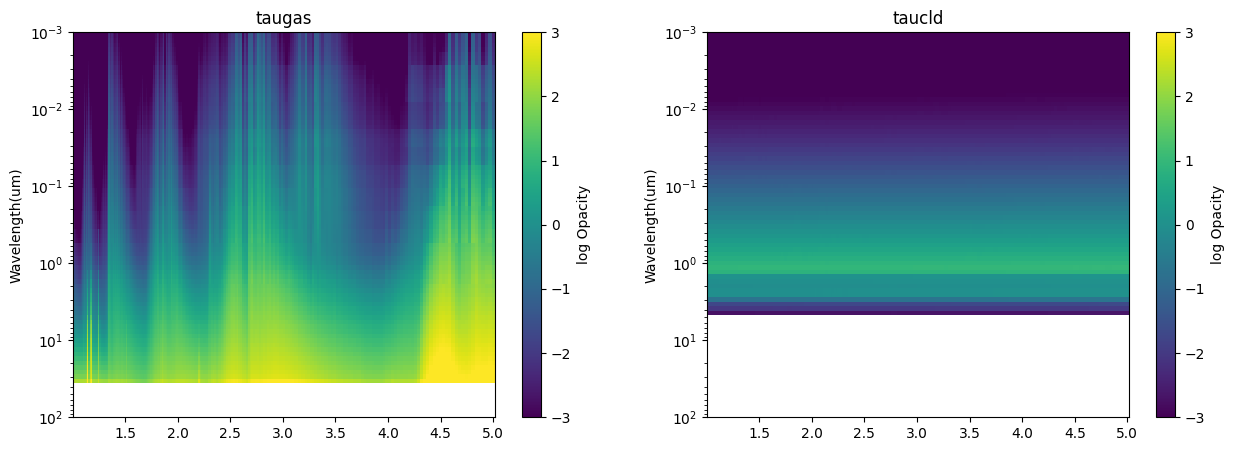

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

ikey = '1449.8_9637.7'

for it, itau in enumerate(['taugas','taucld']):

    tau_bin = []
    for i in range(hot_case['full_output'][itau].shape[0]):
        x,y = jdi.mean_regrid(cldy_hot_output[ikey]['wavenumber'],
                              cldy_hot_output[ikey]['full_output'][itau][i,:,0], R=150)
        tau_bin += [[y]]

    tau_bin = np.array(np.log10(tau_bin))[:,0,:]
    X,Y = np.meshgrid(1e4/x,cldy_hot_output[ikey]['full_output']['layer']['pressure'])
    Z = tau_bin
    pcm=ax[it].pcolormesh(X, Y, Z)
    cbar=fig.colorbar(pcm, ax=ax[it])
    pcm.set_clim(-3.0, 3.0)
    ax[it].set_title(itau)
    ax[it].set_yscale('log')
    ax[it].set_ylim([1e2,1e-3])
    ax[it].set_ylabel('Pressure(bars)')
    ax[it].set_ylabel('Wavelength(um)')
    cbar.set_label('log Opacity')

## References

Gao, Peter, et al. "Aerosols in Exoplanet Atmospheres." Journal of Geophysical Research: Planets 126.4 (2021): e2020JE006655.